## After collecting the data in the previous step, we will do text preprocessing in this step

In [ ]:
!pip install transformers




     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 890kB 22.0MB/s 
     |████████████████████████████████| 2.9MB 13.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=d850451674407a99a65cf020dd0096fd4d1d6cd81ec0831c24394e4ba02dc72f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Import libraries

In [ ]:
#Libraries for Text preprocessing 
import transformers 
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

#Normal computation libraries
import pandas as pd
import numpy as np

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

#Pytorch libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import os

#Set the Random Seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
#Check for gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
import warnings
warnings.simplefilter('ignore')

### Read the data

In [ ]:
#Read the reviews
df = pd.read_csv('Train.csv')
df.head()

,ID,text,label
0,13P0QT0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,-1
1,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1
2,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1
3,U0TTYY8,ak slouma,1
4,68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1


In [ ]:
#We will remove the id for simplicity
df.drop('ID', axis = 1, inplace = True)
df.rename(columns ={'text': 'content', 'label': 'score'} , inplace = True)

df["score"].replace({-1:0,0:1,1:2,}, inplace=True)
df.head()

,content,score
0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,0
1,cha3eb fey9elkoum menghir ta7ayoul ou kressi,0
2,bereau degage nathef ya slim walahi ya7chiw fi...,0
3,ak slouma,2
4,entom titmanou lina a7na 3iid moubarik a7na ch...,0


In [ ]:
#Get the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  70000 non-null  object
 1   score    70000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
df['score'].value_counts()

2    38239
0    29295
1     2466
Name: score, dtype: int64

Text(0, 0.5, 'Score counts')

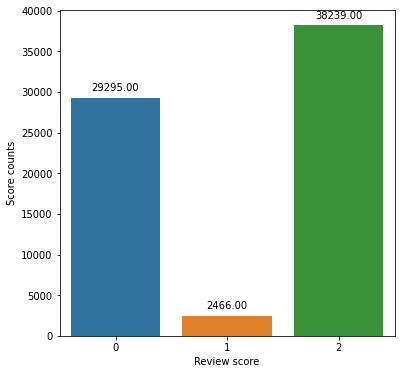

In [ ]:
#We are interested in score, let's check the distribution
plt.rcParams['figure.figsize'] = 6, 6
review_count = sns.countplot(df.score)
class_name = [0,1,2]
for p in review_count.patches:
    review_count.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xlabel("Review score")
plt.ylabel("Score counts")

Text(0, 0.5, 'Score counts')

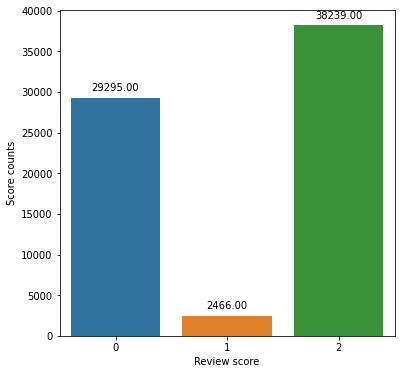

In [ ]:
plt.rcParams['figure.figsize'] = 6, 6
review_count = sns.countplot(df.score)
class_name = [0,1,2]
for p in review_count.patches:
    review_count.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xlabel("Review score")
plt.ylabel("Score counts")

### Data Preprocessing

We need to convert the text to numbers using tokenizer. For training data, BERT requires extra steps like
1. BERT needs special tokens indicating starting and ending of sentence, and special tokens for classification. 
2. The input must be of fixed length (padding for less tokens)
3. Create attention mask indicating importance of token

In [ ]:
#Define the BERT Model
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'   #Cased better here for sentiment analysis might have more weight here

In [ ]:
#Set the tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
#Create a sample sentence for analysis
sample = 'I love NLP. It is very interesting to play with words. Do you like NLP?'

tokens = tokenizer.tokenize(sample)
print("Sentence: ", sample)
print("Tokens: ",tokens)

#Get the ids of tokens from BERT vocab
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token ids: ", token_ids)

Sentence:  I love NLP. It is very interesting to play with words. Do you like NLP?
Tokens:  ['I', 'love', 'NL', '##P', '.', 'It', 'is', 'very', 'interesting', 'to', 'play', 'with', 'words', '.', 'Do', 'you', 'like', 'NL', '##P', '?']
Token ids:  [146, 1567, 21239, 2101, 119, 1135, 1110, 1304, 5426, 1106, 1505, 1114, 1734, 119, 2091, 1128, 1176, 21239, 2101, 136]


In [ ]:
encoding = tokenizer.encode_plus(
  sample,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
#Separator token
print(tokenizer.sep_token, tokenizer.sep_token_id)
#Classification token
print(tokenizer.cls_token, tokenizer.cls_token_id)
#Unknown token
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[UNK] 100


In [ ]:
token_lens = []
#Iterate through all content of reviews
for text in df.content:
    tokens = tokenizer.tokenize(text)
    token_lens.append(len(tokens))

Text(0, 0.5, '% of counts')

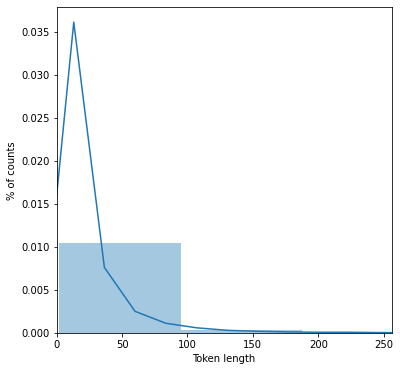

In [ ]:
#Get the distribution plot
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token length')
plt.ylabel('% of counts')

In [ ]:
MAX_LEN = 160

### Create the class for Pytorch Dataset for apps reviews

In [ ]:
class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
#Split the data into train and test
df_train, df_val = train_test_split(df, test_size=0.05, random_state=RANDOM_SEED)
this line is for a testing data set we dont need it in our case
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
#Check the shapes
df_train.shape, df_val.shape, df_test.shape

((66500, 2), (3500, 2))

Create the data loader 

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.score.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
      )

In [ ]:
#Create the data loaders
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
#Check the data loader
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


### As we have preprocessed the text, we will fine-tune BERT for sentiment analysis. Rather than using BERTForSequenceClassification or BERTForQuestionAnswering, we will use BERT model and build our own classifier

In [ ]:
#Load the BERT Model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [ ]:
#Encode the sample text
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

In [ ]:
#Check the shape of last hidden state(Output of the last encoder of BERT)
last_hidden_state.shape

torch.Size([1, 32, 768])

As our length of example sentence is 32, we have hidden state of each token

In [ ]:
#Pooling is applied using BertPooling for simplicity
pooled_output.shape

torch.Size([1, 768])

In [ ]:
#We can check the number of hidden units in BERT using config
bert_model.config.hidden_size

768

#### Create a Sentiment Classifier

In [ ]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
#Create instance
model = SentimentClassifier(len(class_name))
model = model.to(device)

In [ ]:
#Move the example batch to GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [ ]:
#Get the shape of input ids and attention masks
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
#To get the predicted probability for each class, we will apply a softmax layer on the output

F.softmax(model(input_ids, attention_mask), dim = 1)

tensor([[0.4177, 0.2297, 0.3525],
        [0.4552, 0.1072, 0.4375],
        [0.4661, 0.1356, 0.3983],
        [0.5290, 0.0962, 0.3747],
        [0.4130, 0.1930, 0.3941],
        [0.3618, 0.1581, 0.4801],
        [0.4017, 0.1654, 0.4329],
        [0.4523, 0.1633, 0.3843],
        [0.4593, 0.1143, 0.4264],
        [0.4265, 0.1693, 0.4041],
        [0.4003, 0.1951, 0.4046],
        [0.3237, 0.1345, 0.5419],
        [0.5432, 0.1024, 0.3544],
        [0.3002, 0.1505, 0.5493],
        [0.3588, 0.0756, 0.5656],
        [0.5730, 0.1509, 0.2761]], grad_fn=<SoftmaxBackward>)

### Train the model

In [ ]:
#Set the parameters for training as per recommendation by HuggingFace
EPOCHS = 30

#We will use AdamW optimizer 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
#Set the total steps
total_steps = len(train_data_loader) * EPOCHS

#Set the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
#Define a method for training the data
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    
    #Set the model in training mode
    model=model.train()
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        #Get the output
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        #Get the max of softmax
        _, preds = torch.max(outputs, dim=1)
        
        #Calculate the loss
        loss = loss_fn(outputs, targets)
        
        #Update loss and correct prediction
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        #Perform training actions
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)     #Normalize gradients to prevent explosion
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#Define a method for evaluating the model
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#Train the model for 4 epochs
from collections import defaultdict
#Define history and best accuracy
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    print(f'Epoch: {epoch + 1} / {EPOCHS}')
    print('-' * 15)

    #Call the train epoch method
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

    #Print the loss and accuracy
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')


    #Call the val epoch method
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

    #Print the validation loss and accuracy
    print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')
    train_acc=train_acc.item()
    val_acc=val_acc.item()
    #Update the history dictionary
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
      if os.path.isfile('best_model_state.bin'):
        os.remove('best_model_state.bin')                  
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

Epoch: 1 / 30
---------------


KeyboardInterrupt: ignored

In [ ]:
#PLot the graphs to compare accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.6, 1])

## Evaluation

In [ ]:
model.load_state_dict(torch.load("/content/best_model_state.bin"))
these 2 lines is for a testing data set we dont need it in our case
test_accuracy = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print("Test accuracy: ", test_accuracy[0].item())

## Function to get the predictions

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
print(classification_report(y_test, y_pred,labels=class_name))

## Prediction on user input

In [ ]:
review_text = "rakom ki zeby"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_name[prediction]}')

In [ ]:
data_test = pd.read_csv('Test.csv')
data_test.head()

In [ ]:
pred_text = data_test.text.to_numpy()

In [ ]:
predections=[]
for e in pred_text:
  encoded_review = tokenizer.encode_plus(
  e,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  print(f'Review text: {e}')
  print(f'Sentiment  : {class_name[prediction]}')
  predections.append(class_name[prediction])
  


In [ ]:
data_test["label"]=predections
data_test.head()

In [ ]:
data_test.drop('text', axis = 1, inplace = True)
data_test["label"]=data_test["label"]-1
data_test.head()

In [ ]:
df_submission=pd.read_csv('SampleSubmission.csv')
df_submission.head()

In [ ]:
data_test.to_csv(r'Predections.csv', index = False)
